# Evolution in music through the years

This notebook contains all information about our data processing steps.  

*Due to problem with the cluster only the subset of the data set was analysed locally*  

### Also note that we were a group of 3 students, and that one of the student decided to drop the course the week end of the 25, this can be taken into account for this milestone. 

Also you need [spotify API](https://github.com/plamere/spotipy) to get more information from their API

These include data analysis, cleaning, processing, engineering and visualisation.  
For the intermediate milestone we will also provide an updated plan.

In [72]:
%matplotlib inline
# Provided library to access hdf5 files from MillionSong dataset
import getters as hdf5_getters

import re
import time
import numpy as np
import sqlite3 as sq
import os
import pandas as pd
import glob
#import spotify
import matplotlib.pyplot as plt
import seaborn as sns
import json
import urllib.request
from sklearn.decomposition import PCA


from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.utils import resample

## Data Fetching 

In [2]:
local_path = 'C:/Users/M4X/Documents/Uni/EPFL/ADA/ADA/project/data'
#local_path = 'C:/Users\Max-Pc/Downloads/millionsongsubset_full/MillionSongSubset/data'

In [3]:
def get_all_interesting_data(basedir,ext='.h5') :
    datas = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            oneSongData = []
            h5 = hdf5_getters.open_h5_file_read(f)
            
            # Columns wich we want to analyse 
            oneSongData.append( hdf5_getters.get_artist_id(h5))
            oneSongData.append(hdf5_getters.get_artist_name(h5))
            oneSongData.append(hdf5_getters.get_year(h5))
            oneSongData.append(hdf5_getters.get_song_id(h5))
            oneSongData.append(hdf5_getters.get_danceability(h5))
            oneSongData.append(hdf5_getters.get_duration(h5))
            oneSongData.append(hdf5_getters.get_song_hotttnesss(h5))
            oneSongData.append(hdf5_getters.get_title(h5))
            oneSongData.append(hdf5_getters.get_tempo(h5))
            oneSongData.append(hdf5_getters.get_time_signature(h5))
            oneSongData.append(hdf5_getters.get_time_signature_confidence(h5))
            oneSongData.append(hdf5_getters.get_artist_mbtags(h5))
            oneSongData.append(hdf5_getters.get_artist_terms(h5))
            oneSongData.append(hdf5_getters.get_artist_location(h5))
            oneSongData.append(hdf5_getters.get_artist_latitude(h5))
            oneSongData.append(hdf5_getters.get_artist_longitude(h5))
            oneSongData.append(hdf5_getters.get_key(h5))
            oneSongData.append(hdf5_getters.get_key_confidence(h5))
            oneSongData.append(hdf5_getters.get_energy(h5))
            oneSongData.append(hdf5_getters.get_loudness(h5))
            
            h5.close()
            
            # Print progress
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
                
            datas.append(oneSongData)
    return datas

In [4]:
datas = get_all_interesting_data(local_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [5]:
df = pd.DataFrame(datas,columns=['ArtistID','ArtistName','SongYear','SongID','SongDanceability','Duration','SongHotness',\
                                 'SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags',\
                                 'ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude',\
                                 'SongKey', 'SongKeyConfidence', 'SongEnergy', 'SongLoudness'])

## Data Analysis and Cleaing

Since we want to analyze music evolution over time, we cannot use Songs without specified year. They are then dropped.

In [6]:
print("Dropping {} rows.".format(df[df['SongYear'] == 0].shape[0]))
df = df[df['SongYear']>0]

Dropping 5320 rows.


In [7]:
df.columns

Index(['ArtistID', 'ArtistName', 'SongYear', 'SongID', 'SongDanceability',
       'Duration', 'SongHotness', 'SongTitle', 'SongTempo',
       'SongTimeSignature', 'SongTimeSignatureConfidence', 'ArtistMbtags',
       'ArtistTerms', 'ArtistLocation', 'ArtistLatitude', 'ArtistLongitude',
       'SongKey', 'SongKeyConfidence', 'SongEnergy', 'SongLoudness'],
      dtype='object')

In [8]:
df.head()

,ArtistID,ArtistName,SongYear,SongID,SongDanceability,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongEnergy,SongLoudness
1,b'ARMJAGH1187FB546F3',b'The Box Tops',1969,b'SOCIWDW12A8C13D406',0.0,148.03546,NaN,b'Soul Deep',121.274,4,0.384,[b'classic pop and rock'],"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892,6,0.169,0.0,-9.843
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',1982,b'SONHOTT12A8C13493C',0.0,233.40363,NaN,b'Something Girls',119.293,4,0.000,"[b'uk', b'british', b'english']","[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN,0,0.751,0.0,-9.013
4,b'ARXR32B1187FB57099',b'Gob',2007,b'SOFSOCN12A8C143F5D',0.0,209.60608,0.604501,b'Face the Ashes',129.738,4,0.562,[],"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN,2,0.092,0.0,-4.501
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',1984,b'SOIAZJW12AB01853F1',0.0,269.81832,0.265861,b'Pink World',86.643,4,0.487,[],"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN,4,0.717,0.0,-13.496
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',1986,b'SOBONFF12A6D4F84D8',0.0,307.38240,NaN,b'Tonight Will Be Alright',125.197,3,0.211,[b'soul and reggae'],"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN,3,0.524,0.0,-8.346


In [9]:
df.isnull().sum()

ArtistID                          0
ArtistName                        0
SongYear                          0
SongID                            0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
SongKey                           0
SongKeyConfidence                 0
SongEnergy                        0
SongLoudness                      0
dtype: int64

We notice, that 1616/4680 Songs do not have a defined Hotness.  
Furthermore, the Latitude and Longitude of the arists for 2855 Songs is not defined.  
For now we will keep the features and rows with NAN, and we will remove them if it would be neccessary to take the NANs into account.  
Let's have a deeper look at the different columns:

In [10]:
with pd.option_context('mode.use_inf_as_null', True):
    print (df.isnull().sum())

ArtistID                          0
ArtistName                        0
SongYear                          0
SongID                            0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
SongKey                           0
SongKeyConfidence                 0
SongEnergy                        0
SongLoudness                      0
dtype: int64


No features contain infinite values.

In [11]:
df.describe()

,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongEnergy,SongLoudness
count,4680.000000,4680.0,4680.000000,3064.000000,4680.000000,4680.000000,4680.000000,1825.000000,1825.000000,4680.000000,4680.000000,4680.0,4680.000000
mean,1997.232051,0.0,238.781146,0.444377,125.163716,3.586111,0.510216,37.501760,-61.772744,5.272222,0.451835,0.0,-9.683453
std,11.686691,0.0,101.345438,0.222470,35.272251,1.240247,0.375063,16.273911,51.525675,3.547714,0.275340,0.0,5.135927
min,1926.000000,0.0,1.044440,0.000000,0.000000,0.000000,0.000000,-41.280540,-155.434140,0.000000,0.000000,0.0,-51.643000
25%,1993.000000,0.0,181.152200,0.313562,98.698500,3.000000,0.089000,34.053490,-93.264930,2.000000,0.225750,0.0,-12.163000
50%,2001.000000,0.0,227.382400,0.473347,122.226500,4.000000,0.553000,40.102160,-79.385330,5.000000,0.472000,0.0,-8.588500
75%,2006.000000,0.0,278.406080,0.604554,146.572000,4.000000,0.868000,44.979030,-3.996670,8.000000,0.661000,0.0,-5.984500
max,2010.000000,0.0,1598.197100,1.000000,258.677000,7.000000,1.000000,69.651020,174.767140,11.000000,1.000000,0.0,0.566000


By analysing the descriptive statistics of each columns we gained the following insights:

|         |        ArtistID       | ArtistName         |         SongYear        | SongDanceability |       Duration      |   SongHotness   | SongTitle |  SongTempo |    SongTimeSignature   |      SongTimeSignatureConfidence      |                 ArtistMbtags                |                      ArtistTerms                     | ArtistLocation |  ArtistLatitude  |  ArtistLongitude  | SongKey                                                                  | SongKeyConfidence                    | SongEnergy | SongLoudness |
|:-------:|:---------------------:|--------------------|:-----------------------:|:----------------:|:-------------------:|:---------------:|:---------:|:----------:|:----------------------:|:-------------------------------------:|:-------------------------------------------:|:----------------------------------------------------:|:--------------:|:----------------:|:-----------------:|--------------------------------------------------------------------------|--------------------------------------|------------|--------------|
|  format |         string        |       string       |           int           |       float      |        float        |      float      |   string  |    float   |           int          |                 float                 |                    string                   |                        string                        |     string     |       float      |       float       |                                    int                                   |                 float                |    float   |     float    |
|   type  |       categorial      |     categorial     |        continious       |    continious    |      continious     |    continious   |     -     | continious |         Ordinal        |               continious              |                                             |                                                      |                |    continious    |     continious    |                                  Ordinal                                 |              continious              |            |   continous  |
| comment | identifier for artist | name of the Artist | years from 1926 to 2010 |     always 0     | duration in seconds | between 0 and 1 |           |            | values between 0 and 7 | between 0 and 1, 1 is very confident  | comma seperated array with mbtags of artist | comma seperated array with echo nest terms of artist |   town, state  | default latitude | default longitude | 0-11 for [c, c-sharp, d, e-flat, e, f, f-sharp, g, a-flat, a, b-flat, b] | between 0 and 1, 1 is very confident | always 0   |  -51 to 0.5  |

Now that we know a little bit more about the different features, let's have a deeper look at their distribution.

In [12]:
normalized_df = df.copy()

### Song Year

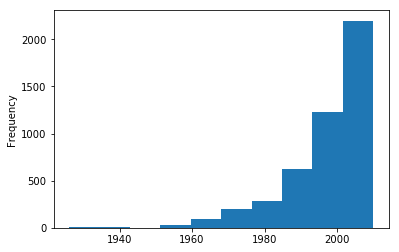

In [13]:
df.SongYear.plot(kind='hist')

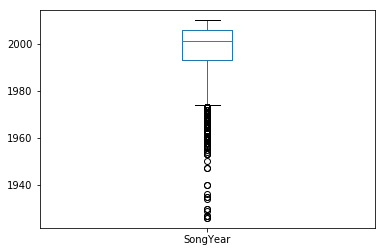

In [14]:
df.SongYear.plot.box()

The distribution of the year feature is negatively skewed.  
The available years span from 1926 to 2010.  
It makes sense to normalize the feature with scaling.
Normalize the year first

In [59]:
normalized_df["SongYearNorm"] = (df.SongYear-df.SongYear.min())/ \
                            (df.SongYear.max()-df.SongYear.min())
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,SongYearNorm
1,b'ARMJAGH1187FB546F3',b'The Box Tops',1969,b'SOCIWDW12A8C13D406',148.03546,NaN,b'Soul Deep',121.274,4,0.384,[b'classic pop and rock'],"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892,6,0.169,-9.843,0.511905
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',1982,b'SONHOTT12A8C13493C',233.40363,NaN,b'Something Girls',119.293,4,0.000,"[b'uk', b'british', b'english']","[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN,0,0.751,-9.013,0.666667
4,b'ARXR32B1187FB57099',b'Gob',2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,b'Face the Ashes',129.738,4,0.562,[],"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN,2,0.092,-4.501,0.964286
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',1984,b'SOIAZJW12AB01853F1',269.81832,0.265861,b'Pink World',86.643,4,0.487,[],"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN,4,0.717,-13.496,0.690476
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',1986,b'SOBONFF12A6D4F84D8',307.38240,NaN,b'Tonight Will Be Alright',125.197,3,0.211,[b'soul and reggae'],"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN,3,0.524,-8.346,0.714286


### Song Danceability

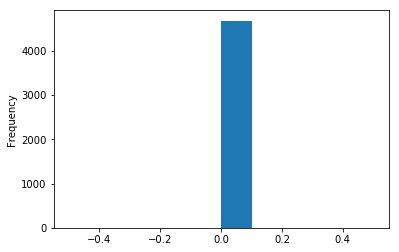

In [16]:
df.SongDanceability.plot(kind='hist')

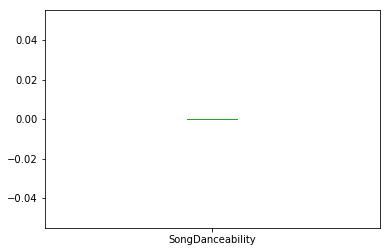

In [17]:
df.SongDanceability.plot.box()

All songs of our cleaned data frame has danceability `0`.  
Therefore we will drop this column.  

In [18]:
normalized_df.drop(labels=['SongDanceability'], axis=1, inplace=True)

### Duration

(35, 20)
(73, 20)


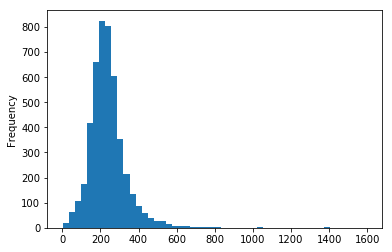

In [19]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

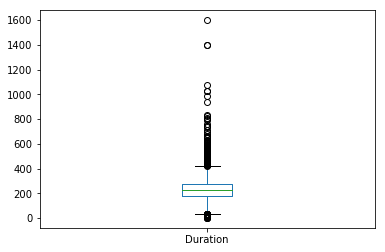

In [20]:
df.Duration.plot.box()

We can see in the histogram, that most of the songs duration are normal distributed.  
However, there are outliers with song durations over 10 minutes and under 60 seconds.   
In our normalized DataFrame we remove the outliers for the duration, since they might deviate too much from the average songs, which we want to analyse.

In [21]:
normalized_df = normalized_df[normalized_df['Duration']>60]
normalized_df = normalized_df[normalized_df['Duration']<600]

### Song Hotness

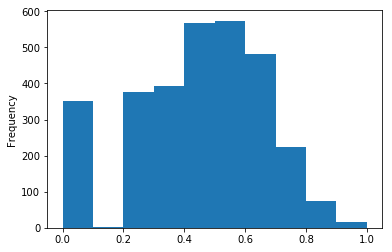

In [22]:
df.SongHotness.plot(kind='hist')

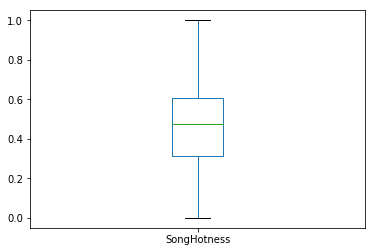

In [23]:
df.SongHotness.plot.box()

The distribution of the Hotness is not skewed.  
There are a few songs where the hotness is missing.  
When analysing hotness remove songs with hotness of zero. But for now we will keep the songs for other analysis tasks.

### Song Tempo 

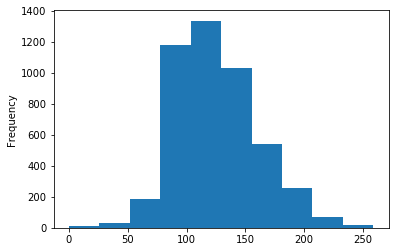

In [24]:
df.SongTempo.plot(kind='hist')

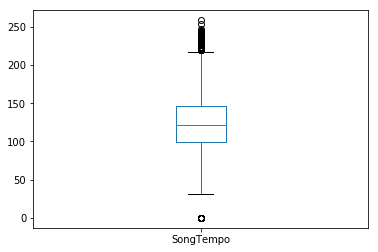

In [25]:
df.SongTempo.plot.box()

The distribution of the tempo is normal. There are some outliers with a very high or low tempo of more than 200 or less than 25.  
We will remove these outliers, since they might deviate from the average songs we want to analyse.

In [26]:
normalized_df = normalized_df[normalized_df['SongTempo']<220]
normalized_df = normalized_df[normalized_df['SongTempo']>25]

### Song Time Signature

The Song Time Signature describes the number of beats per bar.

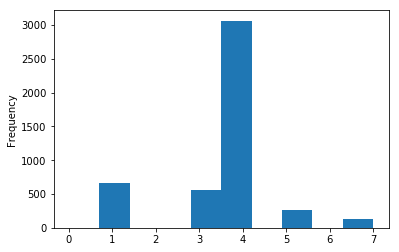

In [27]:
df.SongTimeSignature.plot(kind='hist')

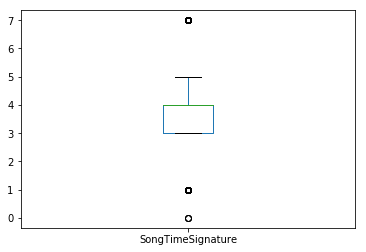

In [28]:
df.SongTimeSignature.plot.box()

The distribution of the Time signature also looks normally distributed, without many outliers.  
Therefore we will keep the feature as it is.

### Song Time Signature Confidence

The Song Time Signature Confidence describes the confidence in the Song Time Signature. It is 1 when the Song Time Signature is very accurate and 0 if is unknown.

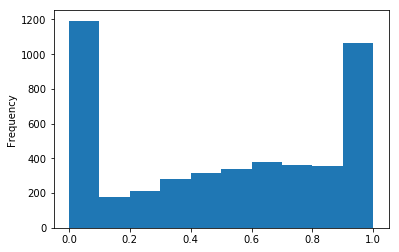

In [29]:
df.SongTimeSignatureConfidence.plot(kind='hist')

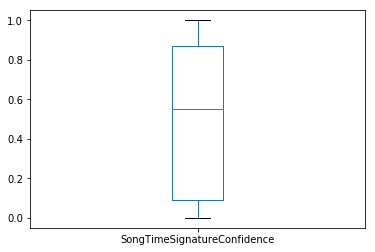

In [30]:
df.SongTimeSignatureConfidence.plot.box()

The majority of songs has either 0 or 1 as confidence. The other confidences are almost equally distributed.    
When analysing TimeSignature we will remove songs with low confidence, but keep the songs for now.

### Artist Location

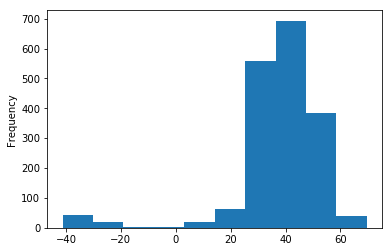

In [31]:
df.ArtistLatitude.plot(kind='hist')

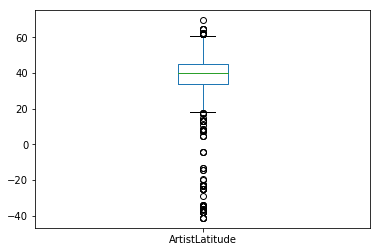

In [32]:
df.ArtistLatitude.plot.box()

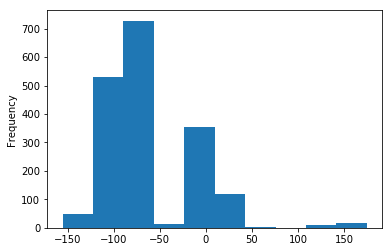

In [33]:
df.ArtistLongitude.plot(kind='hist')

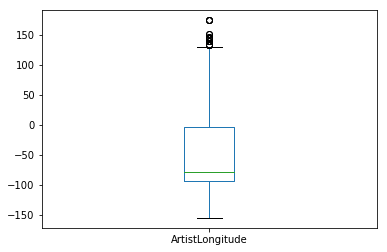

In [34]:
df.ArtistLongitude.plot.box()

We will keep the artist locations for now as they are, since we wanted to look at the correlation between different song types and artist locations.

### Song Key

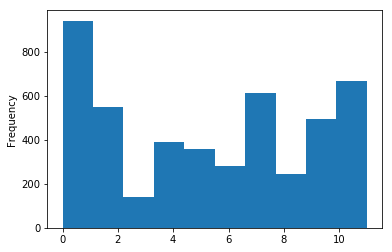

In [35]:
df.SongKey.plot(kind='hist')

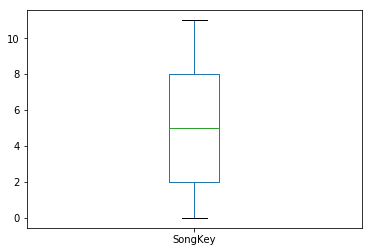

In [36]:
df.SongKey.plot.box()

The key feature has no clear distribution. It contains several peaks which might come from several joined normal distributions for each genre.  
The distribution will be reanalysed for each genre.

### Song Key Confidence

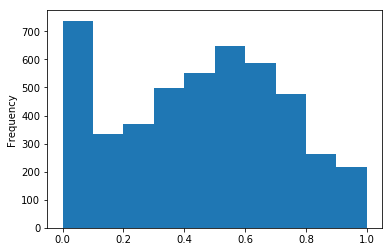

In [37]:
df.SongKeyConfidence.plot(kind='hist')

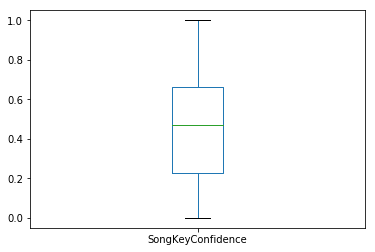

In [38]:
df.SongKeyConfidence.plot.box()

The Song Key Confidence describes the confidence in the Song Key. It is 1 when the Song Key is very accurate and 0 if is unknown.  
The confidence level is not too low, when analysing the key we will remove the songs with low confidence.

### Song Energy

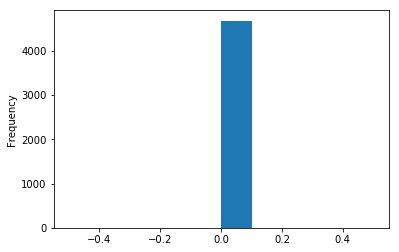

In [39]:
df.SongEnergy.plot(kind='hist')

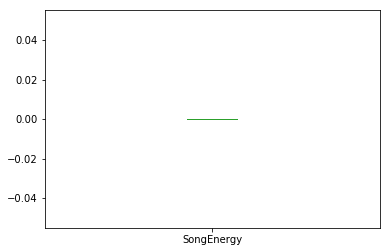

In [40]:
df.SongEnergy.plot.box()

All songs of our cleaned data frame has energy `0`.  
Therefore we will drop this column.  

In [41]:
normalized_df.drop(labels=['SongEnergy'], axis=1, inplace=True)

### Song Loudness

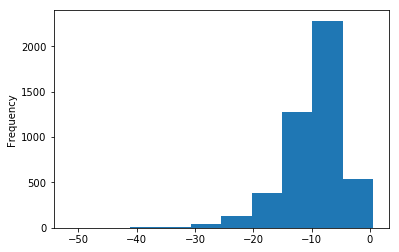

In [42]:
df.SongLoudness.plot(kind='hist')

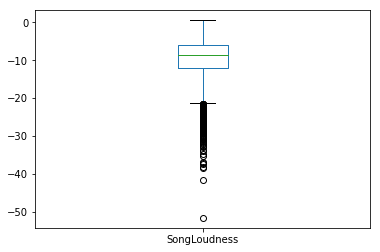

In [43]:
df.SongLoudness.plot.box()

We notice that the loudness is negatively skewed. This means there are a few songs which are really silent.  
We will remove those songs since they deviate from the average song, which we want to analyse.

In [44]:
normalized_df = normalized_df[normalized_df['SongLoudness']>-35]

## Data Correlation

For the correlation we will focus on the rows with a high confidence measure.

In [45]:
corr_df = normalized_df.copy()
corr_df = corr_df[normalized_df['SongTimeSignatureConfidence']>0.5]
corr_df = corr_df[normalized_df['SongKeyConfidence']>0.5]

C:\Users\M4X\AppData\Local\conda\conda\envs\ada\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [55]:
corr = corr_df.corr()
corr

,SongYear,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness
SongYear,1.000000,0.123693,0.121156,0.061124,0.045342,0.005752,-0.011298,0.061663,0.014605,-0.038174,0.354848
Duration,0.123693,1.000000,-0.011613,-0.008254,0.013285,0.010330,0.050131,0.063102,0.002657,0.041513,0.069551
SongHotness,0.121156,-0.011613,1.000000,0.062046,0.039497,0.037246,0.007138,-0.088808,0.036861,-0.096620,0.227774
SongTempo,0.061124,-0.008254,0.062046,1.000000,0.022386,-0.066615,-0.006675,-0.038345,-0.021538,0.024720,0.074821
SongTimeSignature,0.045342,0.013285,0.039497,0.022386,1.000000,-0.016657,0.056957,0.073780,-0.019761,-0.074196,0.026566
SongTimeSignatureConfidence,0.005752,0.010330,0.037246,-0.066615,-0.016657,1.000000,-0.011536,-0.008529,-0.000935,-0.005282,-0.001258
ArtistLatitude,-0.011298,0.050131,0.007138,-0.006675,0.056957,-0.011536,1.000000,0.096827,-0.019033,0.018063,0.046805
ArtistLongitude,0.061663,0.063102,-0.088808,-0.038345,0.073780,-0.008529,0.096827,1.000000,-0.020110,0.000756,-0.063922
SongKey,0.014605,0.002657,0.036861,-0.021538,-0.019761,-0.000935,-0.019033,-0.020110,1.000000,-0.099049,0.026447
SongKeyConfidence,-0.038174,0.041513,-0.096620,0.024720,-0.074196,-0.005282,0.018063,0.000756,-0.099049,1.000000,-0.107177


We seem to have very few correlated features, so we will try to analyze by doing some more analysis on different paramters and maybe doing some feature engineering.  

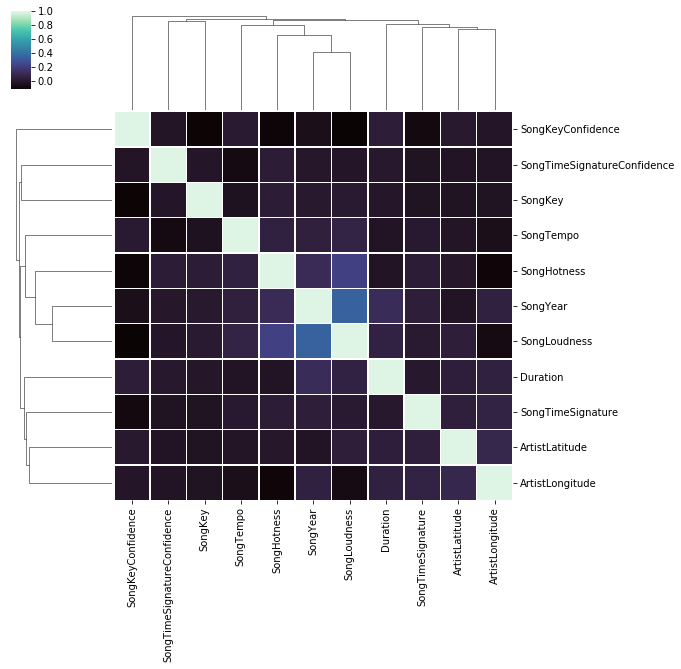

In [56]:
cg = sns.clustermap(corr, linewidth=.5, figsize=(9,9),cmap='mako')
plt.setp(cg)

The most correlated features are SongYear and SongLoudness, SongHotness and SongLoudness, and SongHotness and SongYear.  
The correlation between Hotness and Year exists, since the hotness value is only a snapshot of the hotness in 2010.  
But there seems to be a trend for Loudness over the years.

## Further dependencies

Since we want to analyse the change over time and the time feature is very unbalanced, we will resample our data to a equally distributed time feature.

In [71]:
classes = [0,1950,1960,1970,1980,1990,2000,2010,2015]
df_classes = []
for i in range(1,len(classes)-1):
    df_classes.append(normalized_df[np.logical_and(normalized_df.SongYear > classes[i-1], \
                                 normalized_df.SongYear < classes[i+1])])
for i in range(len(df_classes)):
    print (df_classes[i].shape)

(46, 19)
(163, 19)
(365, 19)
(647, 19)
(1559, 19)
(3532, 19)
(2326, 19)


In [76]:
for i in range(len(df_classes)-1):
    df_classes[i] = resample(df_classes[i], replace=True, n_samples=2326, random_state=42)

resampled_df = df_classes[0]
for i in range(1,len(df_classes)):
    resampled_df = pd.concat([resampled_df, df_classes[i]])


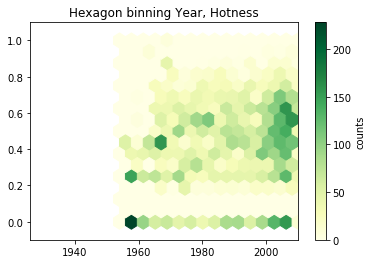

In [78]:
x = resampled_df.SongYear
y = resampled_df.SongHotness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Hotness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

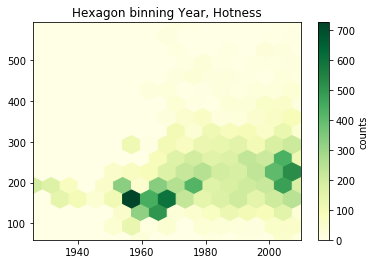

In [79]:
x = resampled_df.SongYear
y = resampled_df.Duration
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Duration")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

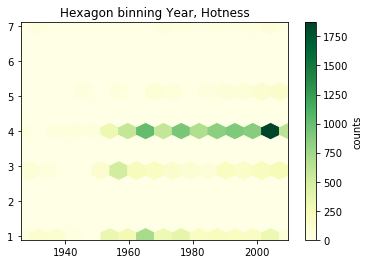

In [80]:
x = resampled_df.SongYear
y = resampled_df.SongTimeSignature
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Time Signature")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

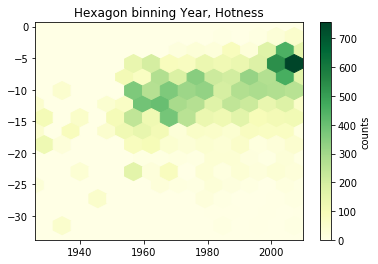

In [81]:
x = resampled_df.SongYear
y = resampled_df.SongLoudness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Loudness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

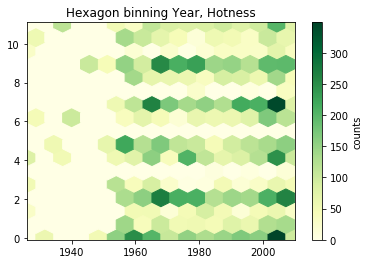

In [82]:
x = resampled_df.SongYear
y = resampled_df.SongKey
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Key")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

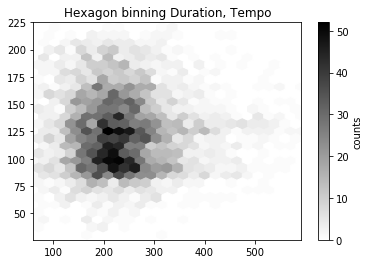

In [53]:
x = normalized_df.Duration
y = normalized_df.SongTempo
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap="gist_yarg")
ax.axis([xmin, xmax, ymin - 5, ymax + 5])
ax.set_title("Hexagon binning Duration, Tempo")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

We can see that most of the song are located in range 90-150 in BPM with duration between 120 - 300 seconds.  
TODO explain other plots

We can't do much more correlation analysis as few datas are correlated and we have a small subset so this is likely to change with a full dataset.

In [62]:
df.ArtistTerms.head()

1     [b'blue-eyed soul', b'pop rock', b'blues-rock'...
3     [b'pop rock', b'new wave', b'dance rock', b'ro...
4     [b'pop punk', b'ska punk', b'breakcore', b'alt...
8     [b'new wave', b'progressive rock', b'space roc...
14    [b'quiet storm', b'soft rock', b'pop', b'urban...
Name: ArtistTerms, dtype: object

In [63]:
df.ArtistMbtags.head()

1           [b'classic pop and rock']
3     [b'uk', b'british', b'english']
4                                  []
8                                  []
14               [b'soul and reggae']
Name: ArtistMbtags, dtype: object

Here we can see that the term of MbTags are more generic a1nd some do not have any tags, while the tags from Terms are really variate. We could do some corssing between this to to see how many cut each other to see if we actually need both of this terms.

## Feature Engineering

Actually all String are bytes string so we will transform them into Str for comparison issues. The concerned features are ArtistName, ArtistLocation, SongTitle, ArtistID and tag from the arrays

In [95]:
def transform(x):
    if('numpy.nd' in str(type(x))):
        result = []
        for a in x:
            result.append(a.decode(encoding='utf-8'))
        return np.array(result)
    elif(x is not None): 
        return x.decode(encoding="utf-8")


In [96]:
normalized_df.ArtistID = df.ArtistID.apply(lambda row: transform(row))
normalized_df.ArtistLocation = df.ArtistLocation.apply(lambda row : transform(row))
normalized_df.ArtistName= df.ArtistName.apply(lambda row : transform(row))
normalized_df.SongTitle = df.SongTitle.apply(lambda row : transform(row))
normalized_df.ArtistMbtags = df.ArtistMbtags.apply(lambda row : transform(row))
normalized_df.ArtistTerms = df.ArtistTerms.apply(lambda row : transform(row))
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,SongYearNorm
1,ARMJAGH1187FB546F3,The Box Tops,1969,b'SOCIWDW12A8C13D406',148.03546,NaN,Soul Deep,121.274,4,0.384,[classic pop and rock],"[blue-eyed soul, pop rock, blues-rock, beach m...","Memphis, TN",35.14968,-90.04892,6,0.169,-9.843,0.511905
3,AR7G5I41187FB4CE6C,Adam Ant,1982,b'SONHOTT12A8C13493C',233.40363,NaN,Something Girls,119.293,4,0.000,"[uk, british, english]","[pop rock, new wave, dance rock, rock, new rom...","London, England",NaN,NaN,0,0.751,-9.013,0.666667
4,ARXR32B1187FB57099,Gob,2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,Face the Ashes,129.738,4,0.562,[],"[pop punk, ska punk, breakcore, alternative me...",,NaN,NaN,2,0.092,-4.501,0.964286
8,AR8ZCNI1187B9A069B,Planet P Project,1984,b'SOIAZJW12AB01853F1',269.81832,0.265861,Pink World,86.643,4,0.487,[],"[new wave, progressive rock, space rock, eurod...",,NaN,NaN,4,0.717,-13.496,0.690476
14,ARIK43K1187B9AE54C,Lionel Richie,1986,b'SOBONFF12A6D4F84D8',307.38240,NaN,Tonight Will Be Alright,125.197,3,0.211,[soul and reggae],"[quiet storm, soft rock, pop, urban, adult con...","Beverly Hills, CA",NaN,NaN,3,0.524,-8.346,0.714286


The amout of different genres is too high. We want to reduce the number of genres.  
Therefore we reduce the genres with an obtained json tree structure from http://musicmap.info/.

In [97]:
#Here we parse the name of the mainGenre
maingenre = ['inl','met','rnr','gld','pwv','hcp','alt','con','pop','cou','rnb','gos','blu','jaz','jam','rap','brb','dnb','hct','tec','hou','tra','dtp']
genreTree = {}
with urllib.request.urlopen('http://musicmap.info/master-genrelist.json') as url:
    data = json.loads(url.read().decode())
    for x in maingenre: 
        name = data.get(x).get('name')
        genreName = name.replace('<span class=\'subtitle\'>','')
        genreName = genreName.replace('</span>','')
        genreNames = re.findall(r'([A-Z]+\s+\'+[A-Z+\'+\s]*|[A-Z+\s+\-]+)',data.get(x).get('name'))
        for g in genreNames:
            if(len(g)>1):
                genreTree[g.replace(' ', '')] = genreName
        for subgenreEntry in data.get(x)["genrelist"]:
            subgenres = re.sub(r"<a.*'>", "", subgenreEntry)
            subgenres = re.sub(r'</a>', "", subgenres)
            subgenres = subgenres.split('/')
            for subgenre in subgenres:
                genreTree[subgenre.strip(' ')] = genreName
                
genreTree

{'(AVANT-GARDE) INDUSTRIAL': 'INDUSTRIAL &amp GOTHIC',
 '(DIRTY) SOUTH RAP, CRUNK &amp SNAP': 'RAP / HIP-HOP MUSIC',
 '(EARLY) GABBER': 'HARDCORE TECHNO',
 '(EARLY) POP ROCK &amp POWER POP': 'POP MUSIC',
 "(EARLY) RHYTHM 'N' BLUES": "RHYTHM 'N' BLUES (R&B)",
 '(ELECTRIC) TEXAS BLUES': 'BLUES',
 '(FREE)TEK(K)NO': 'TECHNO',
 '(MERSEY)BEAT': 'GOLDEN AGE / CLASSIC ROCK',
 '(NEGRO) SPIRITUALS & WORKSONGS': 'GOSPEL &amp; PIONEERS',
 '(ROOTS) REGGAE': 'JAMAICAN (MUSIC) / REGGAE',
 '(WEST COAST) GANGSTA RAP': 'RAP / HIP-HOP MUSIC',
 'ACID HOUSE': 'HOUSE',
 'ACID JAZZ': 'JAZZ',
 'ACID ROCK &amp PSYCHEDELIA': 'GOLDEN AGE / CLASSIC ROCK',
 'ADULT CONTEMPORARY (A.C.)': 'POP MUSIC',
 'AGGREPPO': 'INDUSTRIAL &amp GOTHIC',
 'ALTERNATIVE': 'ALTERNATIVE ROCK / INDIE',
 'ALTERNATIVE COUNTRY': 'COUNTRY',
 'ALTERNATIVE ROCK': 'ALTERNATIVE ROCK / INDIE',
 'AMBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS & ILLBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS &amp ILLBIENT': 'BREAKBEAT',
 "AMBIENT DRUM 'N' B

Now we can reduce all genres to a few main genres. Let's see how the genres from both data sources match:

In [100]:
cnt_hit = 0
cnt_miss = 0

for songGenres in normalized_df['ArtistMbtags']:
    for genre in songGenres:
        if str(genre).upper() in genreTree.keys():
            cnt_hit += 1
        else:
            cnt_miss += 1

print (cnt_hit)
print (cnt_miss)

cnt_hit = 0
cnt_miss = 0

for songGenres in normalized_df['ArtistTerms']:
    for genre in songGenres:
        if str(genre).upper() in genreTree.keys():
            cnt_hit += 1
        else:
            cnt_miss += 1

print (cnt_hit)
print (cnt_miss)

2645
7803
43922
88606


## Manipulation on some of the columns

Here we do some feature extraction, features normalization was done before, and some fetching of other datas from other API

In [67]:
normalized_df['SongTimeWithConfidence'] = df['SongTimeSignature']*df['SongTimeSignatureConfidence']
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongTimeWithConfidence
1,ARMJAGH1187FB546F3,The Box Tops,1969,b'SOCIWDW12A8C13D406',148.03546,NaN,Soul Deep,121.274,4,0.384,[classic pop and rock],"[blue-eyed soul, pop rock, blues-rock, beach m...","Memphis, TN",35.14968,-90.04892,1.536
3,AR7G5I41187FB4CE6C,Adam Ant,1982,b'SONHOTT12A8C13493C',233.40363,NaN,Something Girls,119.293,4,0.000,"[uk, british, english]","[pop rock, new wave, dance rock, rock, new rom...","London, England",NaN,NaN,0.000
4,ARXR32B1187FB57099,Gob,2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,Face the Ashes,129.738,4,0.562,[],"[pop punk, ska punk, breakcore, alternative me...",,NaN,NaN,2.248
8,AR8ZCNI1187B9A069B,Planet P Project,1984,b'SOIAZJW12AB01853F1',269.81832,0.265861,Pink World,86.643,4,0.487,[],"[new wave, progressive rock, space rock, eurod...",,NaN,NaN,1.948
14,ARIK43K1187B9AE54C,Lionel Richie,1986,b'SOBONFF12A6D4F84D8',307.38240,NaN,Tonight Will Be Alright,125.197,3,0.211,[soul and reggae],"[quiet storm, soft rock, pop, urban, adult con...","Beverly Hills, CA",NaN,NaN,0.633


## Concerning Spotify API
We tried to get some data from Spotify, but dues to the time it takes (3 request/s, 1h to fetch hat we want for only the subset, we decided not to parse anything from it unfortunately, a portion of code is still described below to see that we actually tried it.

In [68]:
#token = 'BQAu-KsyKpk7NBP-1ZGCNa-RoHNak0ZNAr3l3mi2In0mLy0o71LAl5OycY1h3K5S8INBp0kvic2lgRFESxry3EW4m7PUfFQZp5dAeSLSgpNs25xfNJbs_KJkuTEChlptb8ZtYF2NiGY4'
#sp = spotipy.Spotify(token)

def spotiAPI(name):
    results = sp.search(q=name, limit=1)
    idd = results['tracks']['items'][0]['artists'][0]['id']
    resultArt = sp.artist(idd)
    #time.sleep(0.02)
    print(resultArt['followers']['total'])
    return resultArt['followers']['total']

In [69]:
#normalized_df['ArtistFollower'] = df.ArtistName.apply(lambda x : spotiAPI(x))

## Updated Plan

### Gained Knowledge

TODO Reflect new knowledge, does data suits needs

### Methods for the future

** Use cluster and full data set, redo analysis **  

The data set contains already collected data so that a natural experiment is not possible.  
Propensity scores are hard to apply to time series. Therefore, we will use sensivity analysis to prove our results.  
  
TODO explain sensivity analysis

* Which features did change (e.g. bpm, beats)?
   * Calculate features aggregated by year, plot time series (with error bars)
   * Can we see a major change of one features over the years?
   * State results with sensivity analysis model
  
  
* How did genres change (e.g. popularity, features of specific genres, higher variance)?
    * Create data frame for each genre with songs of genre
    * Plot number of songs per year
    * Redo question one for features
    * Plot chart which shows span of features per year
    * Look at subgenres?
    * State results with sensivity analysis model
  
  
* How did the distribution of music change (e.g. change of number of genres, variance of features)?
    * Plot chart that shows the numer of features per year
    * Plot chart which shows genre distribution (number of songs per genre) over time
    * State results with sensivity analysis model
  
  
* Train classifier for genre on recent songs
    * Apply it to old songs
    * Evaluate the results
  

Ignore those since we lost one team member?
* Which songs from the past are still trending (why)?
* How did song titles (artist names) change over time?
* Where did (which) songs get released at which time (do dependencies exist between similar Songs)?
  
  
Other interesting analysis:
* Run unsupervised clustering
    * compare clusters to genres
* Compare song and artist name with codec by hashing to get Jacardian distance to get similar song artist name and compare with hotness and other parameters. Maybe even cluster the one close to each other to get another clustering way


It is hard to finally decide which methods will or will not work out, since we only had access to 1/1000 of the dataset.  
Therefore we might drop or add analysis for milestone 3.